In [186]:
import torch 
from torch import nn,utils,functional

In [187]:
corpus_movie_conv = "data/movie-corpus/movie_conversations.txt"
corpus_movie_lines = "data/movie-corpus/movie_lines.txt"

In [188]:
import string
import contractions

def remove_punctuation(text):
    translator = str.maketrans('', '', '"#$%&\'()*+,-/;<=>@[\\]^_`{|}~')
    return text.translate(translator).replace('.',' .').replace('?',' ?').replace('!',' !')

def byte2string(byte_string):
    try:
        decoded_string = byte_string.decode('utf-8')
    except UnicodeDecodeError:
        # If 'utf-8' decoding fails, try 'latin-1'.
        decoded_string = byte_string.decode('latin-1')

    return decoded_string



def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text


In [189]:
ids2dialogue = {}
with open(corpus_movie_lines,'rb') as file:
    dialogue = file.readlines()
    dialogue = [byte2string(dilog).split(" +++$+++ ") for dilog in dialogue]
    for dilog in dialogue:
        ids2dialogue[dilog[0].strip()] =  remove_punctuation(expand_contractions(dilog[-1])).strip()


In [190]:
with open(corpus_movie_conv,'r') as file:
    conv = file.readlines()
    conv = [eval(line.split(' +++$+++ ')[-1]) for line in conv]
    conv_text_corpus = [ids2dialogue[ids] for ids_bucket in conv for ids in ids_bucket]
    
    

In [191]:
question_answer_pair = [(conv_text_corpus[idx].lower(),conv_text_corpus[idx+1].lower()) for idx,en in enumerate(conv_text_corpus[:-1])]

In [192]:
concat_corpus = " ".join(conv_text_corpus).lower().split()

In [193]:
word_frequency = {}
for word in concat_corpus:
    word_frequency[word] = word_frequency.get(word,0) + 1
min_word_freq = 5
word_frequency = {k:v for k,v in word_frequency.items() if v>min_word_freq}

In [194]:
word2idx = {word:idx for idx,word in enumerate(set(word_frequency.keys()),1)}
word2idx['<pad>'] = 0
word2idx['<unknown>']  = len(word2idx) + 1
word2idx['<start>'] = len(word2idx) +1
word2idx['<end>'] = len(word2idx) + 1

idx2word = {idx:word for word,idx in word2idx.items()}

In [195]:
print(f'Total words are : {len(word2idx)}')

Total words are : 15904


In [196]:
max_emb_size  = 25
def encode_ques(sent):
    words = sent.split()[:25]
    return [word2idx.get(word,word2idx['<unknown>']) for word in words] +[word2idx['<pad>']] * (max_emb_size - len(words))

def encode_reply(sent):
    words = sent.split()[:25]
    return [word2idx['<start>']]+ [word2idx.get(word,word2idx['<unknown>']) for word in words] + [word2idx['<end>']] + [word2idx['<pad>']] * (max_emb_size - len(words))

In [198]:
ques_ans_encoded = [(encode_ques(q),encode_reply(a)) for q,a in question_answer_pair]

In [393]:
# import json
# with open('artifacts/PAIR_ENCODED.json','w') as file:
#     json.dump(ques_ans_encoded,file)


# with open('artifacts/WORD_MAP.json','w') as file:
#     json.dump(word2idx,file)

In [213]:
device= 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [214]:
class MovieConversationTextData(utils.data.Dataset):
    
    def __init__(self,path='artifacts/PAIR_ENCODED.json'):
        with open(path) as file:
            self.pairs = json.load(file)
        self.dataset_size = len(self.pairs)
        
    def __getitem__(self,i):
        return torch.LongTensor(self.pairs[i][0]), torch.LongTensor(self.pairs[i][1])
    
    def __len__(self):
        return self.dataset_size


In [219]:
train_loader = utils.data.DataLoader(MovieConversationTextData(),batch_size=100,shuffle=True,pin_memory=True)

In [350]:
for ques, ans in train_loader:
    print(ques.shape, ans.shape)
    break

torch.Size([100, 25]) torch.Size([100, 27])


In [253]:
def create_mask(question,reply,target):
    
    def subsequent_mask(size):
        mask = torch.triu(torch.ones(size,size)).transpose(0,1).type(torch.uint8)
        return mask
    
    question_mask = (question!=0).unsqueeze(1).unsqueeze(1).to(device) #(batch_size,1,1,max_len)
    
    reply_mask = ((reply!=0).unsqueeze(1) & subsequent_mask(reply.shape[-1])).unsqueeze(1).to(device) # (batch_size,1,max_len,max_len)
    
    targetet_mask = (target != 0 ).to(device)
    
    return question_mask,reply_mask,targetet_mask
    

In [267]:
import math
def create_postional_encoding(max_len,d_model):
    pe = torch.zeros(max_len,d_model).to(device)
    for pos in range(max_len):
        for i in range(0,d_model-1,2):
            pe[pos,i] = math.sin((pos/10000**(2*i))/d_model)
            pe[pos,i+1] = math.cos((pos/10000**(2*i))/d_model)
            
    return pe.unsqueeze(0)

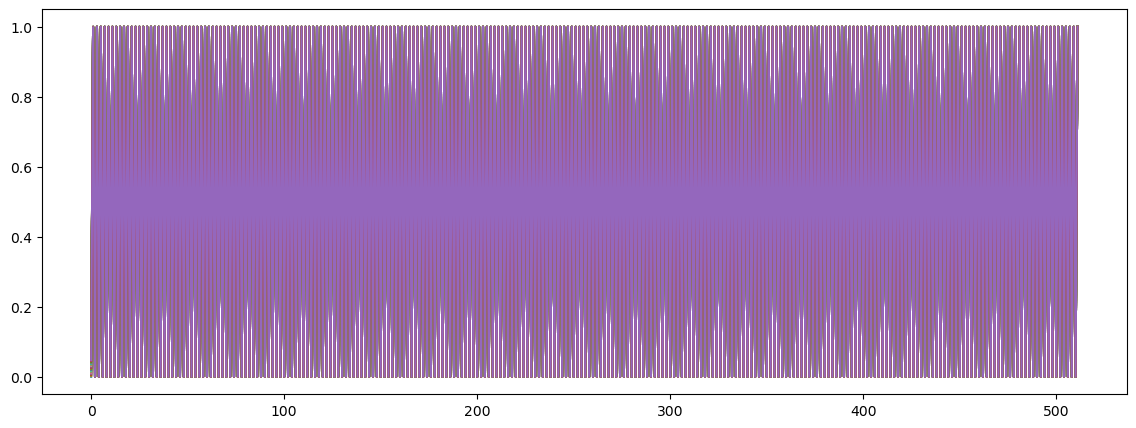

In [293]:

import matplotlib.pyplot as plt
plt.figure(figsize=(14,5))
plt.plot(create_postional_encoding(25,512).squeeze(0).transpose(0,1).to('cpu').numpy());

In [391]:
len(train_loader.dataset)

304712

In [392]:
len(word2idx)

15904

In [361]:
class Embedding(nn.Module):
    
    def __init__(self,vocab_size,embd_size,max_len=50):
        
        super(Embedding,self).__init__()
        
        self.embd_size = embd_size
        self.dropout = nn.dropout(0.1)
        self.embedding = nn.Embedding(vocab_size,embd_size)
        self.postion_encoding = create_postional_encoding(vocab_size,embd_size)
        
    def forward(self,encoded_words):
        # (batch_size,max_len,emd_dim) 
        embeddings = (self.embedding(encoded_words) * math.sqrt(self.embd_size) ) + self.postion_encoding
        embeddings = self.dropout(embeddings)
        return embeddings        

In [ ]:
class MultiHeadAttention(nn.Module):
    super(MultiHeadAttention,self).__init__()
    
    def __init__(self,head,emb_size):
        assert emb_size % head == 0
        
        self.head = head
        self.d_k = emb_size//head
        
        self.query = nn.Linear(emb_size,emb_size)
        self.key = nn.Linear(emb_size,emb_size)
        self.value = nn.Linear(emb_size,emb_size)
        
        self.concat = nn.Linear(emb_size,emb_size)
        
        self.dropout = nn.dropout(0.1)
        
    def forward(self,query,key,value,mask):
        
        query = self.query(query).view(query.size[0],self.h,-1,self.d_k) # query = (100,25,512) --> (100,8,25,64)
        key = self.key(key).view(key.size[0],self.h,-1,self.d_k) 
        value = self.value(value).view(key.size[0],self.h,-1,self.d_k) 
        
        attention = (query @ key.transpose(2,3))/math.sqrt(self.d_k)
        # Apply masked_fill to set padded token positions to a large negative value (-inf)
        attention = attention.masked_fill(mask ==0 ,float('-inf'))
        # Apply softmax to get probabilities
        attention  = self.dropout(nn.functional.softmax(attention,dim=-1)) # (100,8,25,25)
        
        attention = attention @ value # (100,8,25,25) @ (100,8,25,64)
        
        context = attention.transpose(1, 2).contiguous().view(batch_size, -1, self.head * self.d_k)
        
        return self.concat(context)
        

In [387]:
class FeedForward(nn.Module):
    
    
    def __init__(self,emd_size,middle_layer = 2048):
        super(FeedForward,self).__init__()
        
        self.fc1 = nn.Linear(emd_size,middle_layer)
        self.fc2 = nn.Linear(middle_layer,emd_size)
        
        self.dropout = nn.Dropout(0.1)
        
    def forward(self,x):
        out = nn.functional.relu(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

In [388]:
class Encoder(nn.Module):
    
    def __init__(self,head,emb_size):
        super(Encoder,self).__init__()
        
        self.self_multihead = MultiHeadAttention(head,emb_size)
        self.laynorm = nn.LayerNorm(emb_size)
        self.dropout = nn.functional.dropout(0.1)
        
        self.feed_forward = FeedForward(emb_size)
        
    def forward(self,embedding,mask):
        interacted = self.dropout(self.self_multihead(embedding,embedding,embedding,mask))
        
        interacted = self.laynorm(interacted + embedding)
        
        feed_forward = self.dropout(self.feed_forward(interacted))
        
        return self.laynorm(feed_forward + interacted)


In [394]:
class Decoder(nn.Module):
    
    def __init__(self,head,emb_size):
        super(Decoder,self).__init__()
        
        self.self_multihead = MultiHeadAttention(head,emb_size)
        self.src_multihead = MultiHeadAttention(head,emb_size)
        self.laynorm = nn.LayerNorm(emb_size)
        self.dropout = nn.functional.dropout(0.1)
        self.feed_forward = FeedForward(emb_size)
        
    def forward(self,embedding,src_mask,target_mask):
        query = self.dropout(self.self_multihead(embedding,embedding,embedding,target_mask))
        query = self.laynorm(interacted + embedding)
        
        
        interacted = self.dropout(self.self_multihead(embedding,embedding,embedding,src_mask))
        interacted = self.laynorm(interacted + query)
        feed_forward = self.dropout(self.feed_forward(interacted))
        
        return self.laynorm(feed_forward + interacted)       
        
        
        

In [ ]:
class Transformer(nn.Module):
    def __init__(self,head,embd_size,num_layers,word_map,max_len = 50):
        super(Transformer,self).__init__()
        
        vocab_size = len(word_map)
        self.embd = Embedding(vocab_size, embd_size, max_len)
        
        self.encod = nn.ModuleList([Encoder(head,embd_size) for _ in range(num_layers)])
        self.decode = nn.ModuleList([Decoder(head,embd_size) for _ in range(num_layers)])
        
        self.logit = nn.Linear(embd_size,vocab_size)
        
    def encode(self,src_word,src_mask):
        src_embedding = self.encod(src_word)